Sieć perceptronowa - nasz

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, Flatten, Input, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping


sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)


data = pd.read_csv("XAU_1d_data.csv", delimiter=";")
data["Date"] = pd.to_datetime(data["Date"])
data = data.sort_values("Date")


data["Target"] = data["Close"].shift(-1)
data = data.dropna()

features = ["Open", "High", "Low", "Volume", "Close"]
X_raw = data[features].values
y_raw = data["Target"].values.reshape(-1, 1)


n = len(X_raw)
train_idx = int(n * 0.7)
val_idx = int(n * 0.85)

X_train_raw, y_train_raw = X_raw[:train_idx], y_raw[:train_idx]
X_val_raw, y_val_raw = X_raw[train_idx:val_idx], y_raw[train_idx:val_idx]
X_test_raw, y_test_raw = X_raw[val_idx:], y_raw[val_idx:]


scaler_x = StandardScaler().fit(X_train_raw)
scaler_y = StandardScaler().fit(y_train_raw)

X_train, y_train = scaler_x.transform(X_train_raw), scaler_y.transform(y_train_raw)
X_val, y_val = scaler_x.transform(X_val_raw), scaler_y.transform(y_val_raw)
X_test, y_test = scaler_x.transform(X_test_raw), scaler_y.transform(y_test_raw)


TIME_STEPS = 7


def create_sequences(X, y, time_steps=7):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i : (i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)


X_val_with_lookback = np.concatenate((X_train[-TIME_STEPS:], X_val))
y_val_with_lookback = np.concatenate((y_train[-TIME_STEPS:], y_val))

X_test_with_lookback = np.concatenate((X_val[-TIME_STEPS:], X_test))
y_test_with_lookback = np.concatenate((y_val[-TIME_STEPS:], y_test))


X_train_seq, y_train_seq = create_sequences(X_train, y_train, TIME_STEPS)
X_val_seq, y_val_seq = create_sequences(
    X_val_with_lookback, y_val_with_lookback, TIME_STEPS
)
X_test_seq, y_test_seq = create_sequences(
    X_test_with_lookback, y_test_with_lookback, TIME_STEPS
)

print(f"Dane XAU gotowe.")
print(f"Train shapes: {X_train_seq.shape}")
print(f"Val shapes:   {X_val_seq.shape}")
print(f"Test shapes:  {X_test_seq.shape}")

/home/sebastian/Studia/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-01-16 10:35:10.983082: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-16 10:35:11.029408: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Dane XAU gotowe.
Train shapes: (3815, 7, 5)
Val shapes:   (819, 7, 5)
Test shapes:  (820, 7, 5)


2026-01-16 10:35:11.907767: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/sebastian/Studia/.venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [ ]:
class CustomMLPRegression:
    def __init__(self, layer_sizes):
        self.weights = []
        self.biases = []

        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * np.sqrt(
                2 / layer_sizes[i]
            )
            b = np.zeros((1, layer_sizes[i + 1]))
            self.weights.append(w)
            self.biases.append(b)

        self.v_w = [np.zeros_like(w) for w in self.weights]
        self.v_b = [np.zeros_like(b) for b in self.biases]

    def relu(self, x):
        return np.maximum(0, x)

    def relu_deriv(self, x):
        return (x > 0).astype(float)

    def forward(self, X):
        self.activations = [X]
        self.zs = []
        curr = X
        for i in range(len(self.weights)):
            z = np.dot(curr, self.weights[i]) + self.biases[i]
            self.zs.append(z)

            curr = self.relu(z) if i < len(self.weights) - 1 else z
            self.activations.append(curr)
        return self.activations[-1]

    def train(self, X, y, epochs, lr, momentum):
        for _ in range(epochs):
            pred = self.forward(X)
            error = pred - y

            deltas = [error]
            for i in range(len(self.weights) - 1, 0, -1):
                delta = np.dot(deltas[-1], self.weights[i].T) * self.relu_deriv(
                    self.zs[i - 1]
                )
                deltas.append(delta)
            deltas.reverse()

            for i in range(len(self.weights)):
                grad_w = np.dot(self.activations[i].T, deltas[i]) / y.shape[0]
                grad_b = np.mean(deltas[i], axis=0, keepdims=True)

                self.v_w[i] = momentum * self.v_w[i] - lr * grad_w
                self.v_b[i] = momentum * self.v_b[i] - lr * grad_b

                self.weights[i] += self.v_w[i]
                self.biases[i] += self.v_b[i]


def evaluate_mlp(model, X, y_scaled, sc_y):

    pred_scaled = model.forward(X)

    p = sc_y.inverse_transform(pred_scaled)
    t = sc_y.inverse_transform(y_scaled)

    return {
        "mse": mean_squared_error(t, p),
        "mae": mean_absolute_error(t, p),
        "r2": r2_score(t, p),
    }


results_mlp = []
test_params_mlp = {
    "lr": [0.001, 0.01, 0.05, 0.1],
    "epochs": [500, 1000, 1500, 2000],
    "layers": [[5, 16, 1], [5, 16, 16, 1], [5, 32, 16, 1], [5, 32, 16, 8, 1]],
    "momentum": [0.0, 0.5, 0.9, 0.95],
}
base_mlp = {"lr": 0.01, "epochs": 1000, "layers": [5, 16, 1], "mom": 0.9}

print("Rozpoczynam badanie własnej sieci MLP...")
for p_name, p_vals in test_params_mlp.items():
    for val in p_vals:

        display_val = str(val) if isinstance(val, list) else f"{val:.4f}"
        print(f"MLP | Param: {p_name} = {display_val}")

        for r in range(5):
            cfg = base_mlp.copy()
            if p_name == "lr":
                cfg["lr"] = val
            elif p_name == "epochs":
                cfg["epochs"] = val
            elif p_name == "layers":
                cfg["layers"] = val
            elif p_name == "momentum":
                cfg["mom"] = val

            model = CustomMLPRegression(cfg["layers"])
            model.train(X_train, y_train, cfg["epochs"], cfg["lr"], cfg["mom"])

            for s_name, Xs, ys in [
                ("Train", X_train, y_train),
                ("Val", X_val, y_val),
                ("Test", X_test, y_test),
            ]:
                m = evaluate_mlp(model, Xs, ys, scaler_y)
                results_mlp.append(
                    {
                        "model": "MLP (Custom)",
                        "param": p_name,
                        "val": str(val),
                        "run": r,
                        "set": s_name,
                        "mse": m["mse"],
                        "mae": m["mae"],
                        "r2": m["r2"],
                    }
                )

df_mlp = pd.DataFrame(results_mlp)
print("Badanie MLP zakończone.")

Rozpoczynam badanie własnej sieci MLP...
MLP | Param: lr = 0.0010
MLP | Param: lr = 0.0100
MLP | Param: lr = 0.0500
MLP | Param: lr = 0.1000
MLP | Param: epochs = 500.0000
MLP | Param: epochs = 1000.0000
MLP | Param: epochs = 1500.0000
MLP | Param: epochs = 2000.0000
MLP | Param: layers = [5, 16, 1]
MLP | Param: layers = [5, 16, 16, 1]
MLP | Param: layers = [5, 32, 16, 1]
MLP | Param: layers = [5, 32, 16, 8, 1]
MLP | Param: momentum = 0.0000
MLP | Param: momentum = 0.5000
MLP | Param: momentum = 0.9000
MLP | Param: momentum = 0.9500
Badanie MLP zakończone.


In [ ]:
def get_optimizer(name, lr):
    if name == "Adam":
        return Adam(learning_rate=lr)
    if name == "SGD":
        return SGD(learning_rate=lr)
    if name == "RMSprop":
        return RMSprop(learning_rate=lr)
    return Adam(learning_rate=lr)


def run_dl_experiment(model_type):
    results = []

    tests = {
        "layers": [1, 2, 3, 4],
        "lr": [0.0001, 0.001, 0.01, 0.05],
        "units": [16, 32, 64, 128],
        "epochs": [30, 50, 100, 200],
        "optimizer": ["Adam", "SGD", "RMSprop"],
    }

    base = {"layers": 1, "units": 64, "lr": 0.001, "epochs": 50, "optimizer": "Adam"}

    print(f"--- Rozpoczynam badanie modelu: {model_type} ---")

    for p_name, p_vals in tests.items():
        for val in p_vals:
            print(f"{model_type} | {p_name} = {val}")
            for r in range(5):
                cfg = base.copy()
                cfg[p_name] = val

                model = Sequential()
                model.add(Input(shape=(TIME_STEPS, X_train_seq.shape[2])))

                for i in range(cfg["layers"]):
                    return_seq = i < cfg["layers"] - 1
                    if model_type == "LSTM":
                        model.add(LSTM(cfg["units"], return_sequences=return_seq))
                    else:
                        model.add(
                            Conv1D(
                                cfg["units"],
                                kernel_size=3,
                                padding="same",
                                activation="relu",
                            )
                        )

                if model_type == "CNN":
                    model.add(Flatten())

                model.add(Dense(1))

                opt = get_optimizer(cfg.get("optimizer", "Adam"), cfg["lr"])
                model.compile(optimizer=opt, loss="mse")

                es = EarlyStopping(
                    monitor="val_loss", patience=10, restore_best_weights=True
                )

                model.fit(
                    X_train_seq,
                    y_train_seq,
                    validation_data=(X_val_seq, y_val_seq),
                    epochs=cfg["epochs"],
                    batch_size=64,
                    callbacks=[es],
                    verbose=0,
                )

                for s_name, Xs, ys in [
                    ("Train", X_train_seq, y_train_seq),
                    ("Val", X_val_seq, y_val_seq),
                    ("Test", X_test_seq, y_test_seq),
                ]:
                    preds_scaled = model.predict(Xs, verbose=0)
                    preds = scaler_y.inverse_transform(preds_scaled)
                    y_real = scaler_y.inverse_transform(ys)

                    results.append(
                        {
                            "model": model_type,
                            "param": p_name,
                            "val": str(val),
                            "run": r,
                            "set": s_name,
                            "mse": mean_squared_error(y_real, preds),
                            "mae": mean_absolute_error(y_real, preds),
                            "r2": r2_score(y_real, preds),
                        }
                    )
    return results


res_lstm = run_dl_experiment("LSTM")
res_cnn = run_dl_experiment("CNN")

df_dl = pd.DataFrame(res_lstm + res_cnn)
df_all = pd.concat([df_mlp, df_dl], ignore_index=True)


df_all.to_excel("XAU_Final_Results_Raw.xlsx", index=False)
print("Badania zakończone. Wyniki zapisane.")

--- Rozpoczynam badanie modelu: LSTM ---
LSTM | layers = 1


W0000 00:00:1768556138.848978    2271 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


LSTM | layers = 2
LSTM | layers = 3
LSTM | layers = 4
LSTM | lr = 0.0001
LSTM | lr = 0.001
LSTM | lr = 0.01
LSTM | lr = 0.05
LSTM | units = 16
LSTM | units = 32
LSTM | units = 64
LSTM | units = 128
LSTM | epochs = 30
LSTM | epochs = 50
LSTM | epochs = 100
LSTM | epochs = 200
LSTM | optimizer = Adam
LSTM | optimizer = SGD
LSTM | optimizer = RMSprop
--- Rozpoczynam badanie modelu: CNN ---
CNN | layers = 1
CNN | layers = 2
CNN | layers = 3
CNN | layers = 4
CNN | lr = 0.0001
CNN | lr = 0.001
CNN | lr = 0.01
CNN | lr = 0.05
CNN | units = 16
CNN | units = 32
CNN | units = 64
CNN | units = 128
CNN | epochs = 30
CNN | epochs = 50
CNN | epochs = 100
CNN | epochs = 200
CNN | optimizer = Adam
CNN | optimizer = SGD
CNN | optimizer = RMSprop
Badania zakończone. Wyniki zapisane.


In [ ]:
def objective(trial):

    n_layers = trial.suggest_int("n_layers", 1, 3)
    n_units = trial.suggest_int("n_units", 32, 128)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    dropout_rate = trial.suggest_float("dropout", 0.0, 0.3)

    model = Sequential()
    model.add(Input(shape=(TIME_STEPS, X_train_seq.shape[2])))

    for i in range(n_layers):
        return_seq = i < n_layers - 1
        model.add(LSTM(n_units, return_sequences=return_seq))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    model.add(Dense(1))

    opt = Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss="mse")

    model.fit(
        X_train_seq,
        y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=30,
        batch_size=64,
        verbose=0,
    )

    val_loss = model.evaluate(X_val_seq, y_val_seq, verbose=0)
    return val_loss


print("--- Start Optuna Optimization (LSTM) ---")
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print("Najlepsze parametry znalezione przez Optunę:")
print(study.best_params)


best_params = study.best_params

[I 2026-01-16 11:07:30,791] A new study created in memory with name: no-name-bf1a5754-2394-418e-a66b-f1b6b1c00a89


--- Start Optuna Optimization (LSTM) ---


[I 2026-01-16 11:07:37,553] Trial 0 finished with value: 0.0075304326601326466 and parameters: {'n_layers': 1, 'n_units': 52, 'lr': 0.0005559660451523156, 'dropout': 0.206859964997607}. Best is trial 0 with value: 0.0075304326601326466.
[I 2026-01-16 11:07:45,458] Trial 1 finished with value: 0.008258101530373096 and parameters: {'n_layers': 1, 'n_units': 94, 'lr': 0.00012235947362599397, 'dropout': 0.13748670803176843}. Best is trial 0 with value: 0.0075304326601326466.
[I 2026-01-16 11:07:54,853] Trial 2 finished with value: 0.010878070257604122 and parameters: {'n_layers': 1, 'n_units': 80, 'lr': 0.00014851439262203594, 'dropout': 0.019920250860304932}. Best is trial 0 with value: 0.0075304326601326466.
[I 2026-01-16 11:08:07,925] Trial 3 finished with value: 0.009737130254507065 and parameters: {'n_layers': 2, 'n_units': 73, 'lr': 0.00317666892283714, 'dropout': 0.29584602096715795}. Best is trial 0 with value: 0.0075304326601326466.
[I 2026-01-16 11:08:29,516] Trial 4 finished wit

Najlepsze parametry znalezione przez Optunę:
{'n_layers': 1, 'n_units': 88, 'lr': 0.006729416622515235, 'dropout': 0.2178663443226455}


/tmp/ipykernel_2271/1567996933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df["val_num"] = pd.to_numeric(subset_df["val"])


Generowanie wykresów wpływu parametrów...


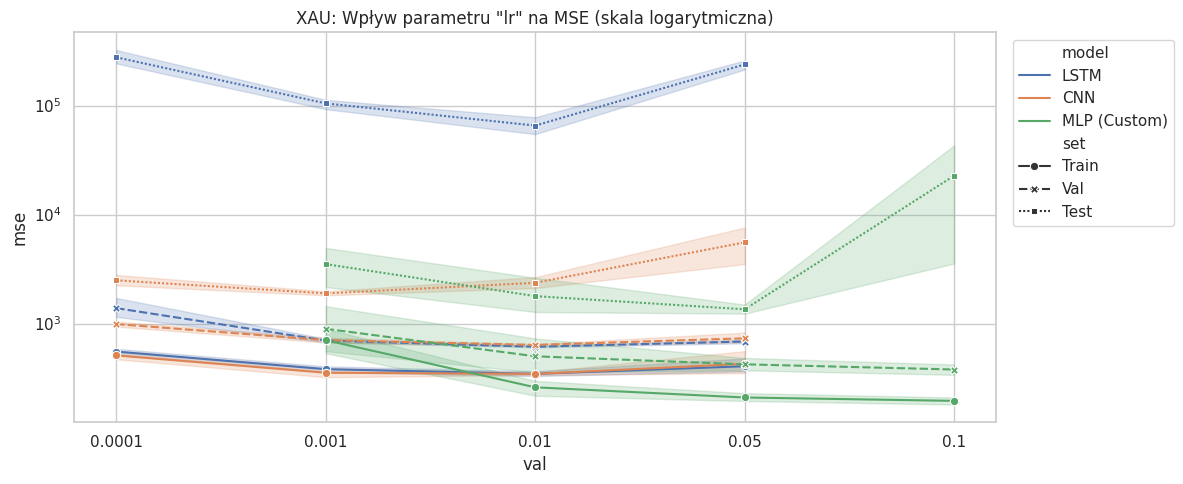

/tmp/ipykernel_2271/1567996933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df["val_num"] = pd.to_numeric(subset_df["val"])


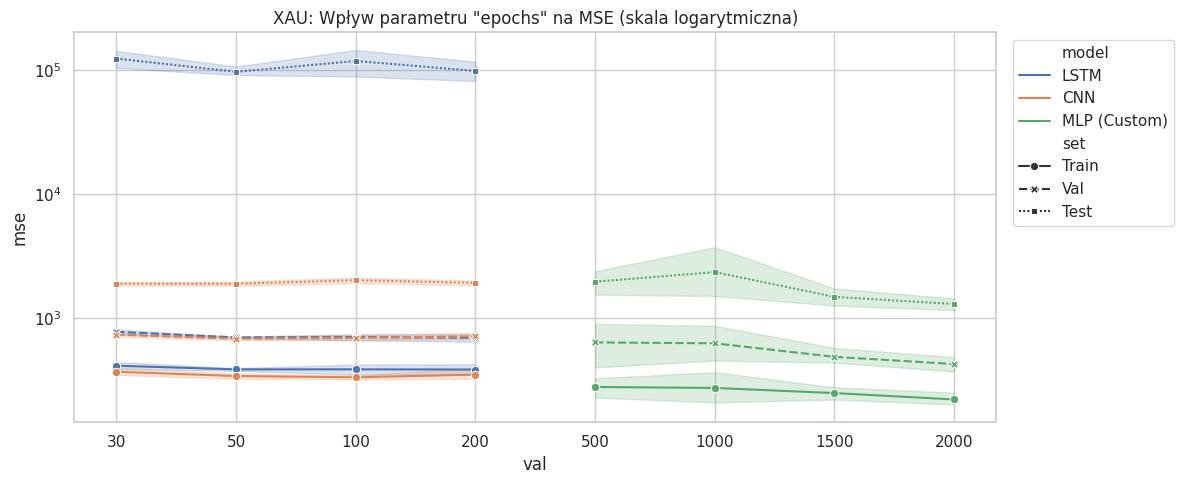

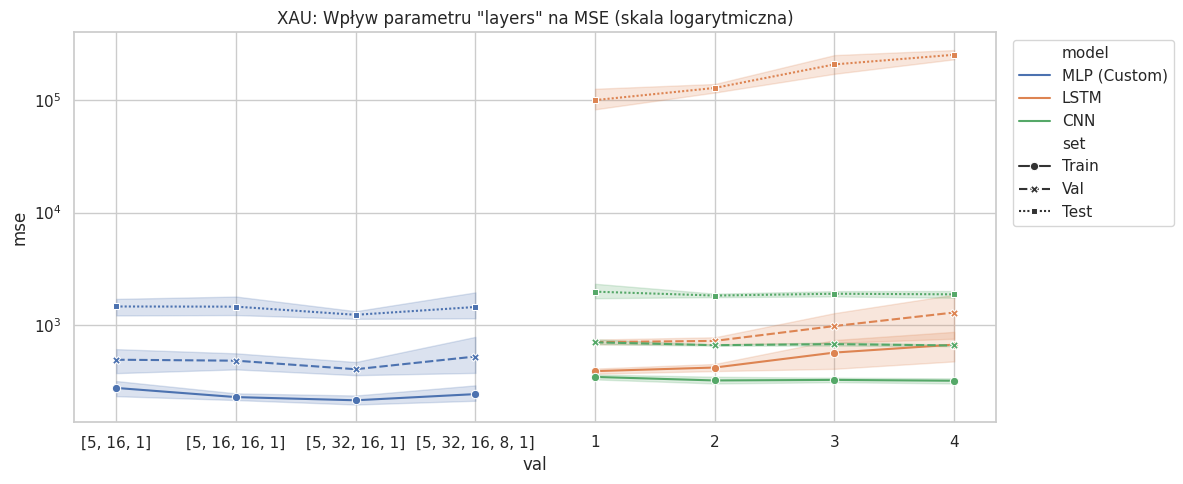

/tmp/ipykernel_2271/1567996933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df["val_num"] = pd.to_numeric(subset_df["val"])


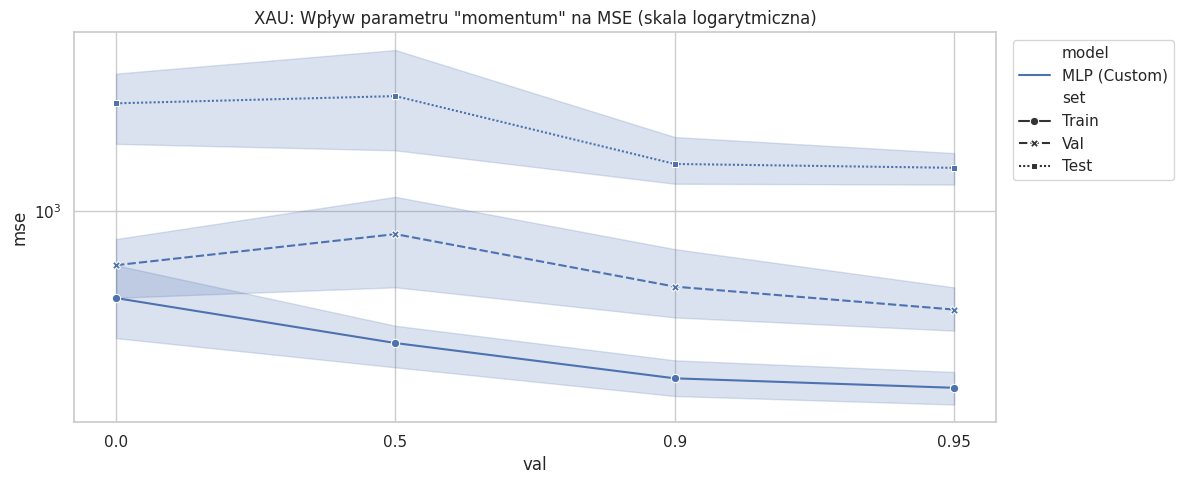

/tmp/ipykernel_2271/1567996933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df["val_num"] = pd.to_numeric(subset_df["val"])


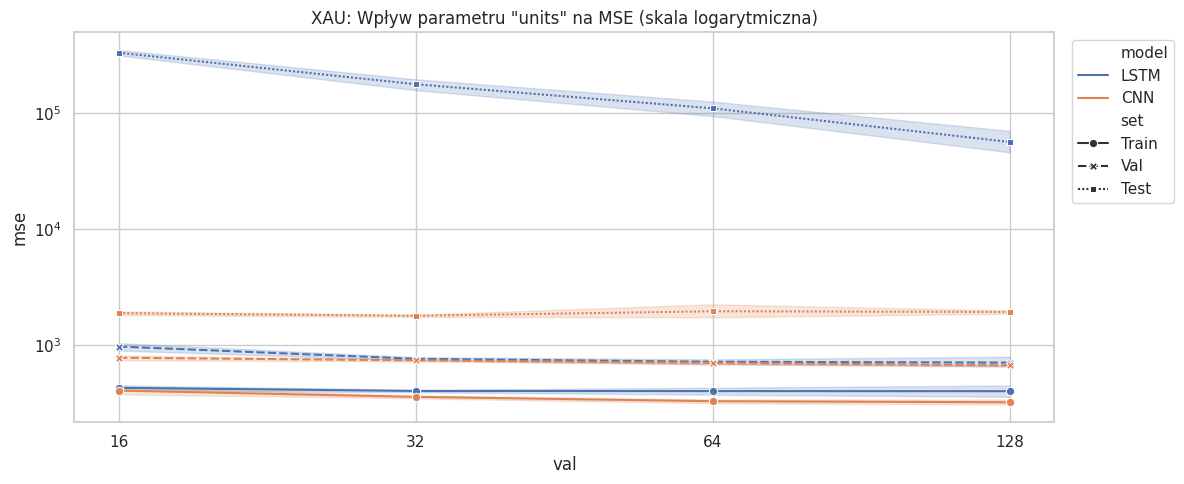

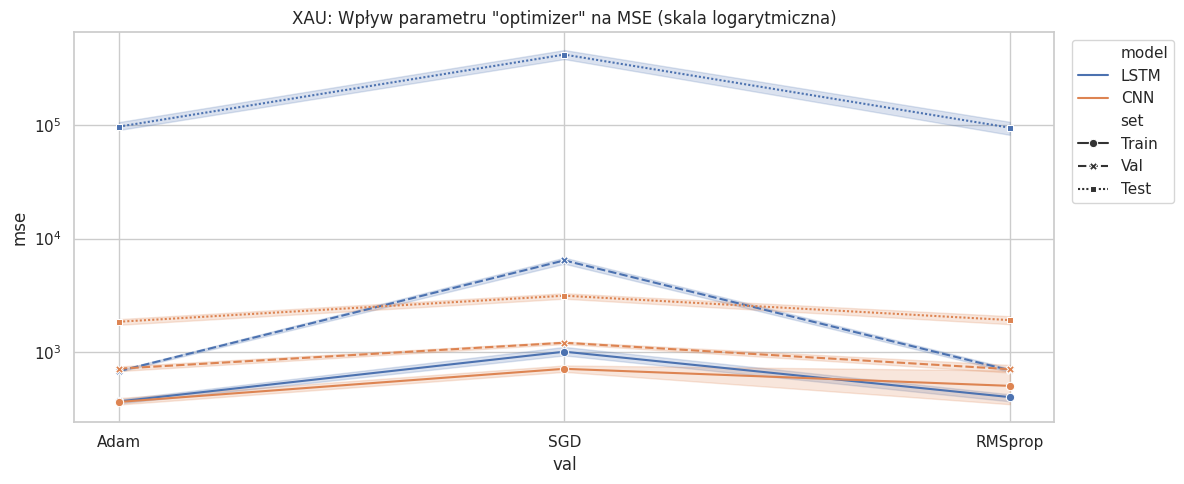

Generowanie map ciepła (Heatmaps)...


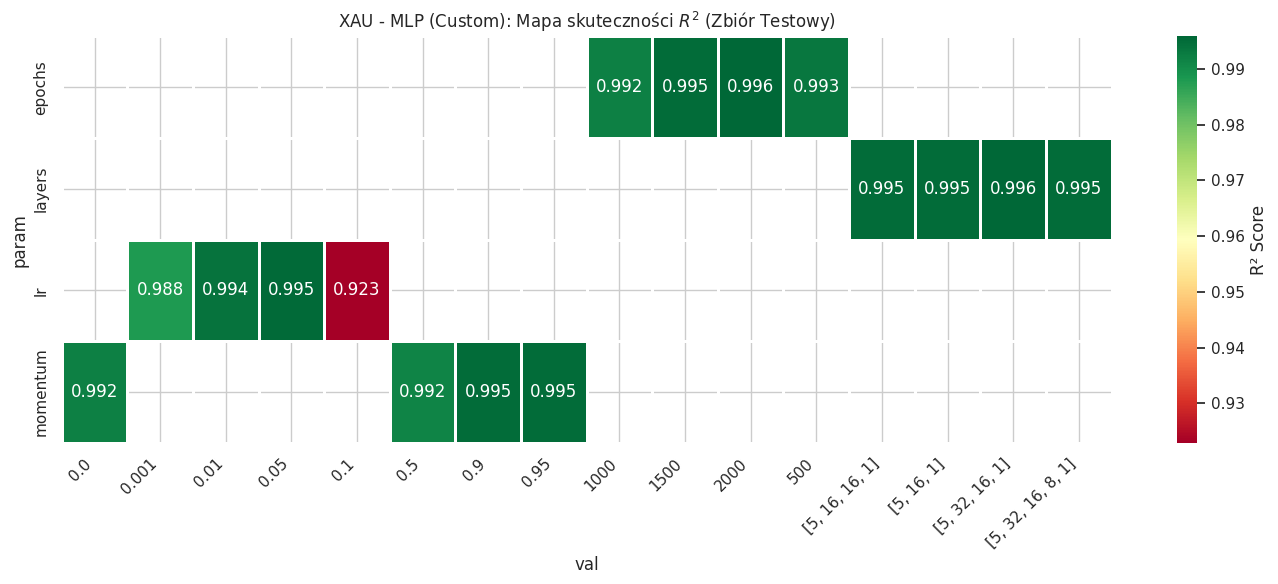

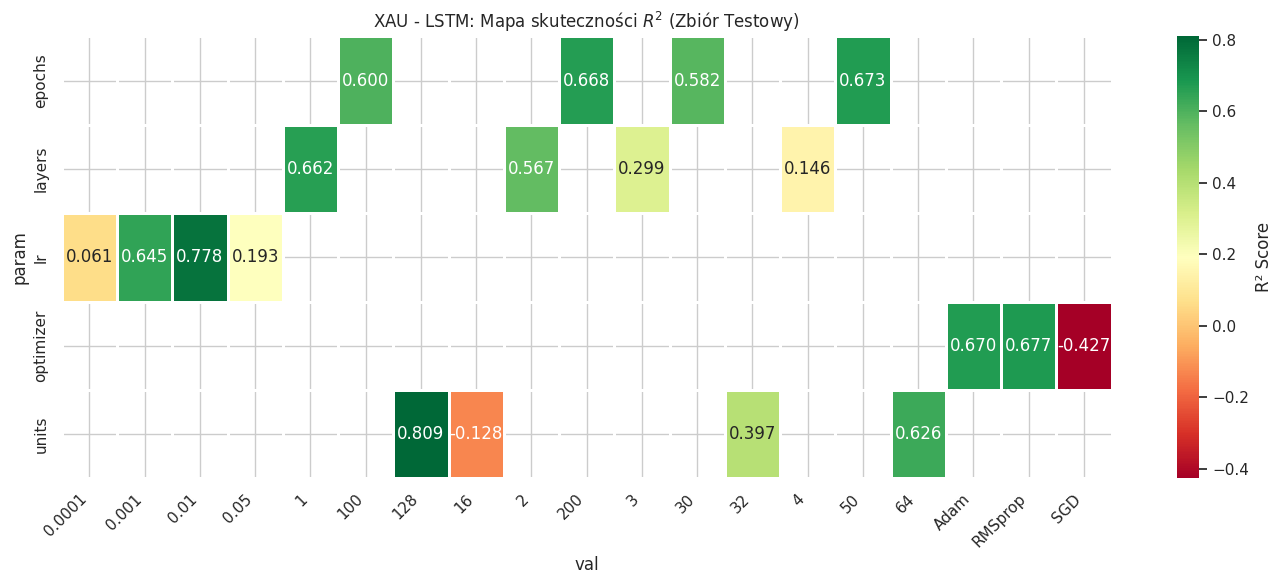

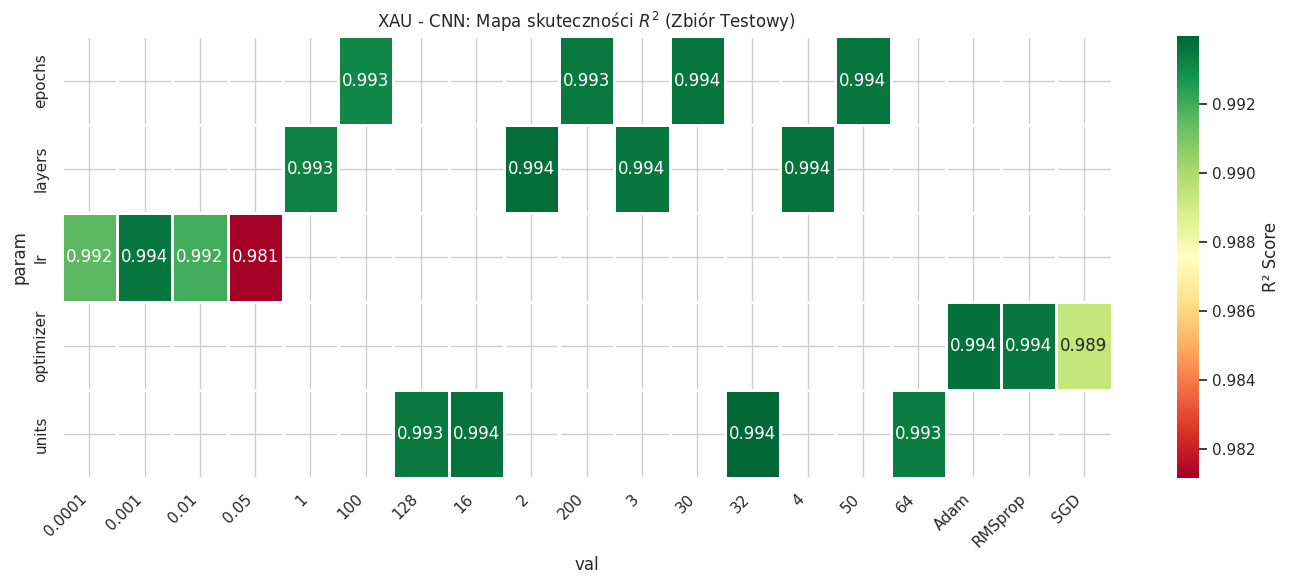

In [ ]:
df_plot = df_all.copy()
df_plot["set"] = df_plot["set"].str.capitalize()


params_to_plot = df_plot["param"].unique()

print("Generowanie wykresów wpływu parametrów...")
for p in params_to_plot:
    plt.figure(figsize=(12, 5))
    subset_df = df_plot[df_plot["param"] == p]

    try:
        subset_df["val_num"] = pd.to_numeric(subset_df["val"])
        subset_df = subset_df.sort_values("val_num")
    except:
        pass

    sns.lineplot(
        data=subset_df,
        x="val",
        y="mse",
        hue="model",
        style="set",
        markers=True,
        dashes=True,
        err_style="band",
    )
    plt.title(f'XAU: Wpływ parametru "{p}" na MSE (skala logarytmiczna)')
    plt.yscale("log")
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


print("Generowanie map ciepła (Heatmaps)...")
for model_name in df_plot["model"].unique():
    test_data = df_plot[(df_plot["model"] == model_name) & (df_plot["set"] == "Test")]

    if not test_data.empty:

        pivot_data = test_data.pivot_table(index="param", columns="val", values="r2")

        if not pivot_data.empty:
            fig, ax = plt.subplots(figsize=(14, 6))
            sns.heatmap(
                pivot_data,
                annot=True,
                cmap="RdYlGn",
                fmt=".3f",
                linewidths=1,
                linecolor="white",
                cbar_kws={"label": "R² Score"},
                ax=ax,
            )
            plt.title(f"XAU - {model_name}: Mapa skuteczności $R^2$ (Zbiór Testowy)")
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()
            plt.show()

Trenowanie najlepszego modelu LSTM do pogłębionej analizy reszt...


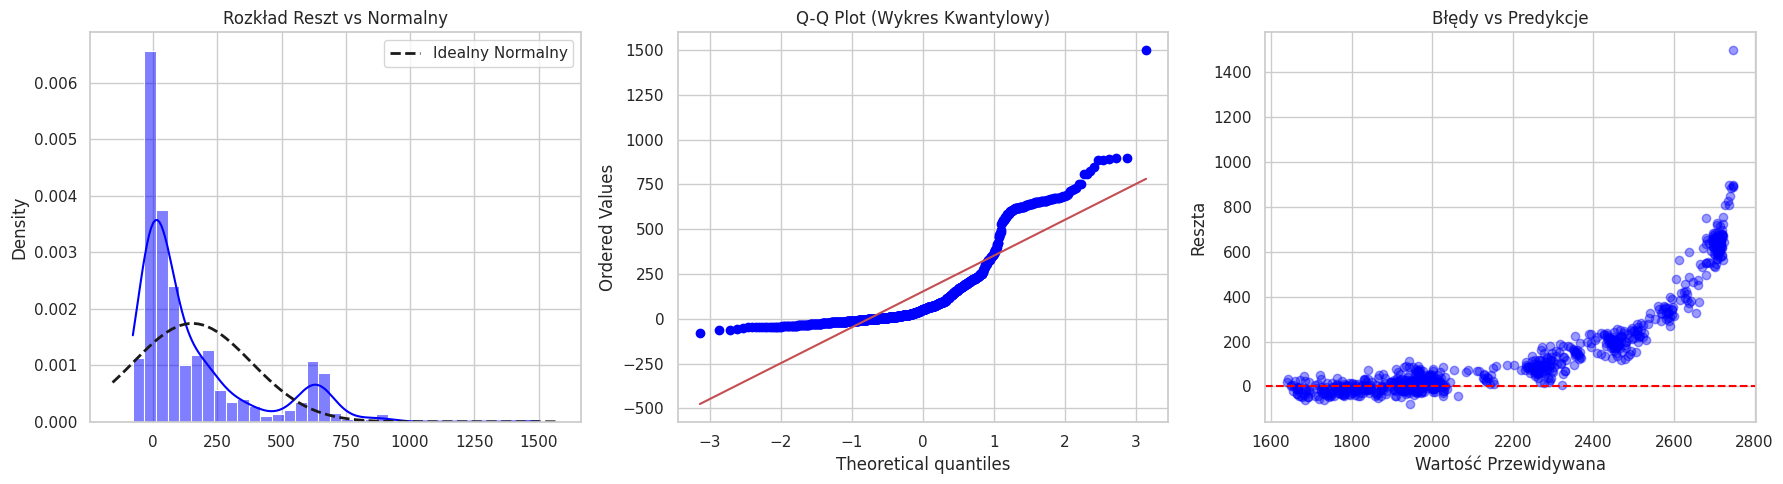


--- WNIOSKI STATYSTYCZNE DLA XAU ---
Średnia błędów: 152.6040 (powinna być bliska 0)
Skośność (Skewness): 1.6244 (0 = symetryczny)
Kurtoza (Kurtosis): 2.1464 (0 = normalny, >0 = grube ogony)
Test Jarque-Bera p-value: 3.2620e-113
=> WNIOSEK: Rozkład reszt NIE JEST normalny (typowe dla rynków finansowych).

Zapisano tabelę wyników do: XAU_Final_Summary_Stats.xlsx


In [ ]:
import scipy.stats as stats


print("Trenowanie najlepszego modelu LSTM do pogłębionej analizy reszt...")

best_model = Sequential()
best_model.add(Input(shape=(TIME_STEPS, X_train_seq.shape[2])))


try:
    bp = best_params
except NameError:
    bp = {"n_layers": 2, "n_units": 64, "dropout": 0.0, "lr": 0.001}

for i in range(bp.get("n_layers", 2)):
    best_model.add(
        LSTM(bp.get("n_units", 64), return_sequences=(i < bp.get("n_layers", 2) - 1))
    )
    if bp.get("dropout", 0.0) > 0:
        best_model.add(Dropout(bp.get("dropout", 0.0)))

best_model.add(Dense(1))
best_model.compile(optimizer=Adam(learning_rate=bp.get("lr", 0.001)), loss="mse")


best_model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=64, verbose=0)


y_pred_scaled = best_model.predict(X_test_seq, verbose=0)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_seq)


residuals = y_true - y_pred
residuals = residuals.flatten()


fig, axes = plt.subplots(1, 3, figsize=(18, 5))


sns.histplot(residuals, kde=True, ax=axes[0], color="blue", stat="density")

mu, std = stats.norm.fit(residuals)
xmin, xmax = axes[0].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
axes[0].plot(x, p, "k--", linewidth=2, label="Idealny Normalny")
axes[0].set_title("Rozkład Reszt vs Normalny")
axes[0].legend()


stats.probplot(residuals, dist="norm", plot=axes[1])
axes[1].get_lines()[0].set_markerfacecolor("blue")
axes[1].get_lines()[0].set_markeredgecolor("blue")
axes[1].set_title("Q-Q Plot (Wykres Kwantylowy)")


axes[2].scatter(y_pred, residuals, alpha=0.4, color="blue")
axes[2].axhline(0, color="red", linestyle="--")
axes[2].set_title("Błędy vs Predykcje")
axes[2].set_xlabel("Wartość Przewidywana")
axes[2].set_ylabel("Reszta")

plt.tight_layout()
plt.show()


stat, p_value = stats.jarque_bera(residuals)
print(f"\n--- WNIOSKI STATYSTYCZNE DLA XAU ---")
print(f"Średnia błędów: {np.mean(residuals):.4f} (powinna być bliska 0)")
print(f"Skośność (Skewness): {stats.skew(residuals):.4f} (0 = symetryczny)")
print(
    f"Kurtoza (Kurtosis): {stats.kurtosis(residuals):.4f} (0 = normalny, >0 = grube ogony)"
)
print(f"Test Jarque-Bera p-value: {p_value:.4e}")

if p_value < 0.05:
    print(
        "=> WNIOSEK: Rozkład reszt NIE JEST normalny (typowe dla rynków finansowych)."
    )
else:
    print("=> WNIOSEK: Rozkład reszt przypomina rozkład normalny.")


summary_table = df_all.groupby(["model", "param", "val", "set"])[
    ["mse", "mae", "r2"]
].agg(["mean", "std", "max"])

file_name = "XAU_Final_Summary_Stats.xlsx"
with pd.ExcelWriter(file_name) as writer:
    summary_table.to_excel(writer, sheet_name="Aggregated Stats")
    df_all.to_excel(writer, sheet_name="Raw Data")
print(f"\nZapisano tabelę wyników do: {file_name}")